# NBA Game Prediction: Logistic Regression
Written by Nicholas Cannon 22241579

In [971]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)

%matplotlib inline

DATA_DIR = os.path.join('..', 'data', 'processed', 'teams')
STATE = 42
team_ids = os.listdir(DATA_DIR)

In [975]:
def preprocess_team(team_id, drop_cols='attempts', season_avg=False, window=5, test_size=0.2):
    """
    Preprocess the given teams data set with configurable options
    """
    df = pd.read_csv(os.path.join(DATA_DIR, team_id))

    # shift label up 1 game
    df['WON'] = df['WON'].shift(periods=-1)
    df.dropna(inplace=True)

    # separate features and labels (and drop non feature cols)
    X = df.drop(['GAME_ID', 'DATE', 'SEASON', 'TEAM', 'OPPONENT', 'WON'], axis=1)
    y = df['WON']

    # drop derived cols
    if drop_cols == 'percentages':
        X = X.drop(['FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'RBC'], axis=1)
    elif drop_cols == 'attempts':
        X = X.drop(['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'ORBC', 'DRBC',], axis=1)
    elif drop_cols != '':
        raise ValueError("drop_cols must equal 'percentages', 'attempts' or ''")

    # exlcude home game flag from any kind of averages
    home = X['HOME']
    X.drop(['HOME'], axis=1, inplace=True)

    # Averaging scheme
    if season_avg:
        X = X.expanding().mean()
    else:
        X = X.rolling(window).mean()
        X.dropna(inplace=True) # drop first few games
        y = y[window-1:]
    
    X['HOME'] = home

    return train_test_split(X, y, test_size=test_size, random_state=STATE)


def train_team(team_id, clf, **preprocess_args):
    X_train, X_test, y_train, y_test = preprocess_team(team_id, **preprocess_args)
    clf.fit(X_train, y_train)
    return clf.best_estimator_, X_train, X_test, y_train, y_test, clf.score(X_test, y_test)


def train_all(team_ids, **preprocess_args):
    models = {}
    scores = []

    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('k_bins', KBinsDiscretizer(strategy='kmeans')),
    ('sgd', SGDClassifier(loss='log', random_state=STATE))
    ])
    params = {
        'k_bins__n_bins': [8, 10, 12],
        'sgd__class_weight': [None, 'balanced'],
        'sgd__penalty': ['l1', 'l2', 'none'],
    }

    clf = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=5)

    for team_id in tqdm(team_ids):
        estimator, *data, score = train_team(team_id, clf, **preprocess_args)
        models[team_id] = {'clf': estimator, 'data': data}
        scores.append(score)

    # print stats
    print('Mean score = {}'.format(np.mean(scores)))
    print('Max score = {}'.format(np.max(scores)))
    print('Min score = {}'.format(np.min(scores)))

    return models


def plot_total_cf(models):
    cf = np.zeros((2, 2))
    total = 0
    for team, model in models.items():
        y_pred = model['clf'].predict(model['data'][1])
        total += len(y_pred)
        cf = np.add(cf, confusion_matrix(model['data'][-1], y_pred))

    mat = ConfusionMatrixDisplay(cf)
    mat.plot(cmap=plt.cm.Blues, values_format='.0f')

## Experiment 1: 5 Game moving Average, Dropping attempts

100%|██████████| 30/30 [01:35<00:00,  3.18s/it]
Mean score = 0.5404761904761906
Max score = 0.6428571428571429
Min score = 0.4387755102040816


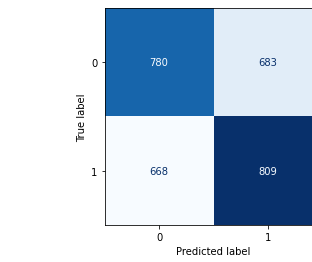

In [976]:
models = train_all(team_ids, drop_cols='attempts', season_avg=False, window=5)
plot_total_cf(models)

## Experiment 2: Season Average, Dropping attempts

100%|██████████| 30/30 [01:47<00:00,  3.57s/it]
Mean score = 0.5508417508417509
Max score = 0.696969696969697
Min score = 0.4444444444444444


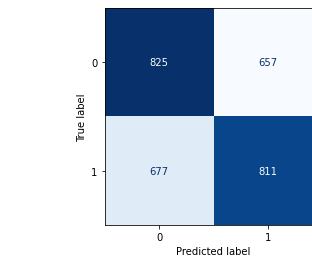

In [977]:
models = train_all(team_ids, drop_cols='attempts', season_avg=True)
plot_total_cf(models)

## Experiment 3: Game Moving Average, Dropping Percentages

100%|██████████| 30/30 [01:40<00:00,  3.34s/it]
Mean score = 0.5462585034013606
Max score = 0.6224489795918368
Min score = 0.41836734693877553


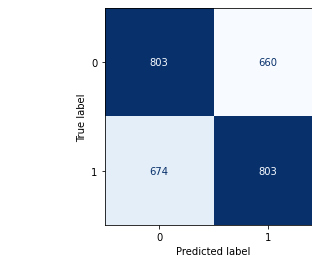

In [978]:
models = train_all(team_ids, drop_cols='percentages', season_avg=False, window=5)
plot_total_cf(models)

## Experiment 4: Season Average, Dropping percentages

100%|██████████| 30/30 [01:55<00:00,  3.86s/it]
Mean score = 0.5538720538720538
Max score = 0.696969696969697
Min score = 0.41414141414141414


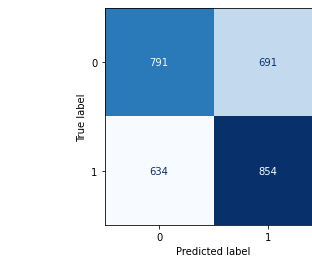

In [979]:
models = train_all(team_ids, drop_cols='percentages', season_avg=True)
plot_total_cf(models)